In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esn import ESN

In [2]:
# データの読み込み
def read_sunspot_data(file_name):
    data = np.empty(0)
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            data = np.hstack((data, float(tmp[3])))  # 3rd column
    return data

# 黒点数データ
sunspots = read_sunspot_data(file_name='data/SN_ms_tot_V2.0.txt')

# データのスケーリング
data_scale = 1.0
data = sunspots*data_scale

In [3]:
# 入力層
N_u = 1
N_x = 300
input_scale = 1
rec_scale = 1.0
rho = 0.9
leaking_rate = 1
activation_func = np.tanh
seed = 0

# ESNのインスタンスを作成
esn = ESN(N_u, N_x, input_scale, rec_scale, rho, leaking_rate, activation_func, seed)

In [4]:
# 予測日程先を指定
step = [1, 5]  

# 訓練・検証データ長
T_train = 2500
T_test1 = data.size - T_train - step[0]
T_test5 = data.size - T_train - step[1]

# 訓練・検証用情報
train_U1 = data[:T_train].reshape(-1, 1)
train_D1 = data[step[0]:T_train + step[0]].reshape(-1, 1)
test_U1 = data[T_train:T_train + T_test1].reshape(-1, 1)
test_D1 = data[T_train + step[0]:T_train + T_test1 + step[0]].reshape(-1, 1)
train_U5 = data[:T_train].reshape(-1, 1)
train_D5 = data[step[1]:T_train + step[1]].reshape(-1, 1)
test_U5 = data[T_train:T_train + T_test5].reshape(-1, 1)
test_D5 = data[T_train + step[1]:T_train + T_test5 + step[1]].reshape(-1, 1)

In [5]:
######## 学習データに対して
# リザバー状態行列の計算
stateCollectMat_train1 = esn.compute_reservoir_states(train_U1)
stateCollectMat_train5 = esn.compute_reservoir_states(train_U5)

# 学習（疑似逆行列）
Wout1 = esn.train(stateCollectMat_train1, train_D1)
Wout5 = esn.train(stateCollectMat_train5, train_D5)

# 予測出力
Y_pred_train1 = esn.predict(Wout1, stateCollectMat_train1)
Y_pred_train5 = esn.predict(Wout5, stateCollectMat_train5)

######## テストデータに対して
# リザバー状態行列の計算
stateCollectMat_test1 = esn.compute_reservoir_states(test_U1)
stateCollectMat_test5 = esn.compute_reservoir_states(test_U5)

# 予測出力
Y_pred_test1 = esn.predict(Wout1, stateCollectMat_test1)
Y_pred_test5 = esn.predict(Wout5, stateCollectMat_test5)

Computing Reservoir States: 100%|███████████████████████████████| 786/786 [00:00<00:00, 6533.29it/s]


In [6]:
# 訓練誤差評価（NRMSE）
RMSE_train1 = np.sqrt(((train_D1 / data_scale - Y_pred_train1 / data_scale) ** 2).mean())
NRMSE_train1 = RMSE_train1 / np.sqrt(np.var(train_D1 / data_scale))
RMSE_train5 = np.sqrt(((train_D5 / data_scale - Y_pred_train5 / data_scale) ** 2).mean())
NRMSE_train5 = RMSE_train5 / np.sqrt(np.var(train_D5 / data_scale))


# 検証誤差評価（NRMSE）
RMSE_test1 = np.sqrt(((test_D1 / data_scale - Y_pred_test1 / data_scale) ** 2).mean())
NRMSE_test1 = RMSE_test1 / np.sqrt(np.var(test_D1 / data_scale))
RMSE_test5 = np.sqrt(((test_D5 / data_scale - Y_pred_test5 / data_scale) ** 2).mean())
NRMSE_test5 = RMSE_test5 / np.sqrt(np.var(test_D5 / data_scale))

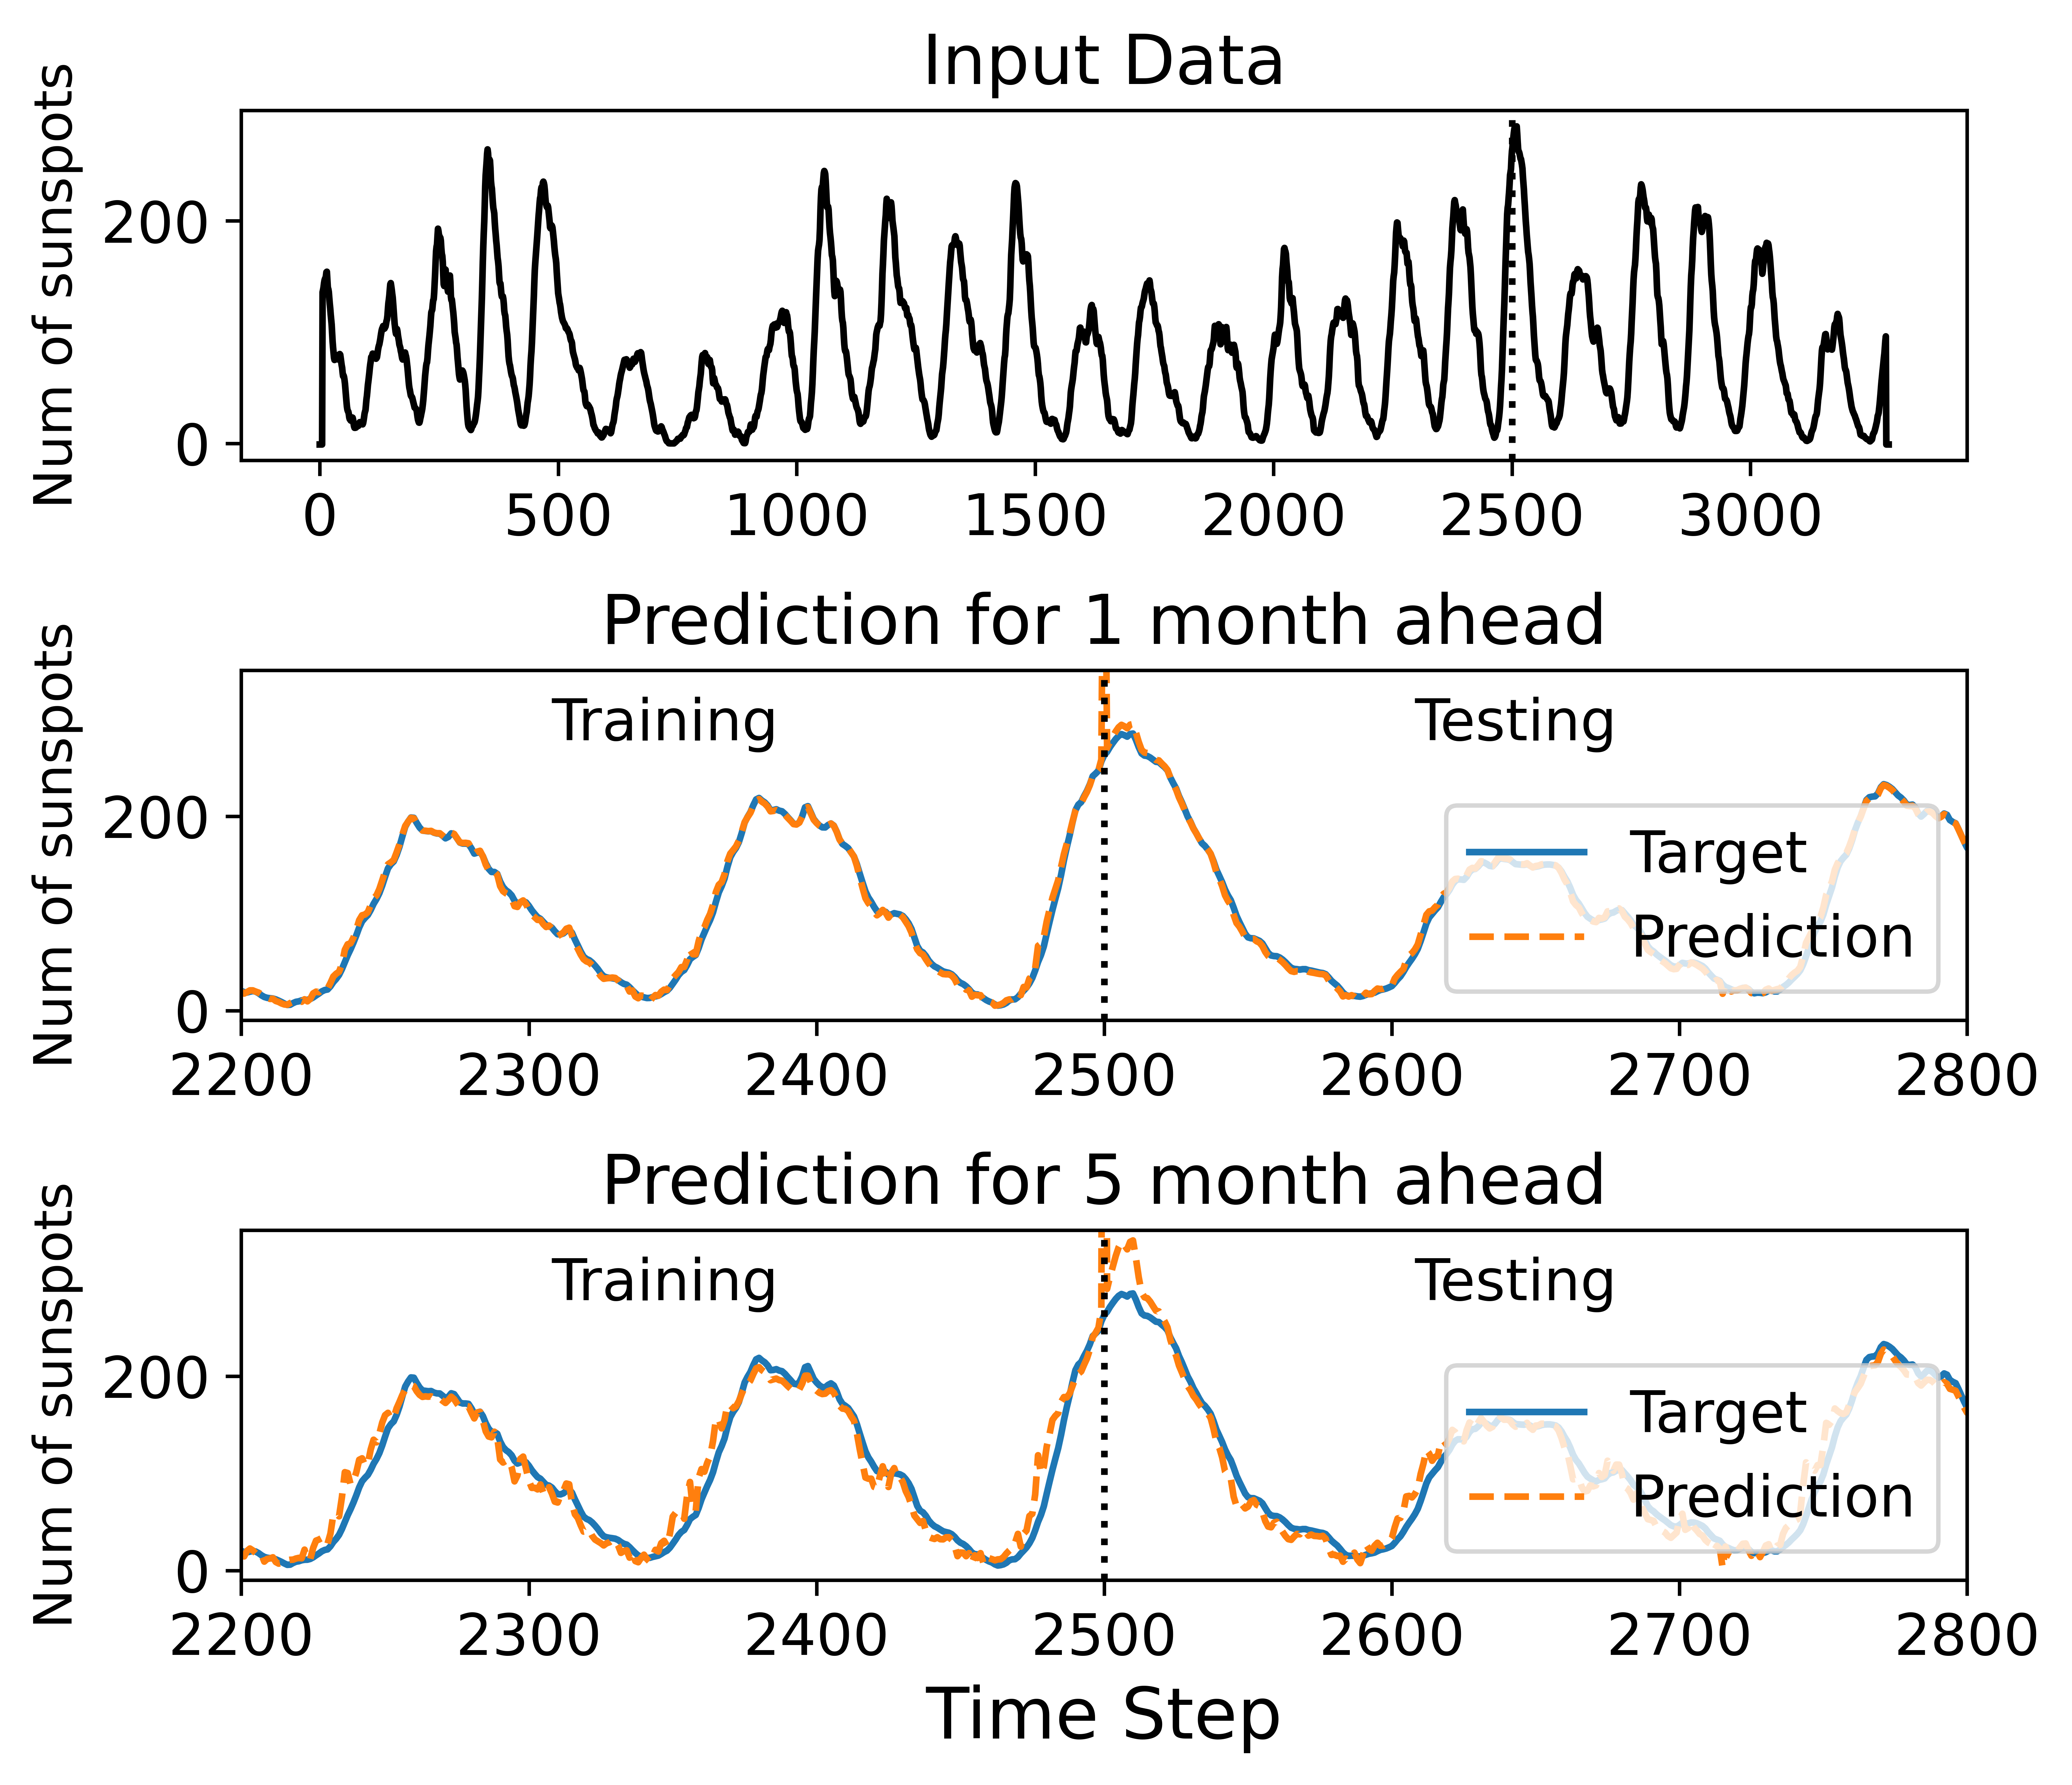

In [7]:
# 表示用にデータを加工
Y_pred_train1 = Y_pred_train1.reshape(-1,)
Y_pred_test1 = Y_pred_test1.reshape(-1,)
Y_pred1 = np.concatenate((Y_pred_train1, Y_pred_test1))

Y_pred_train5 = Y_pred_train5.reshape(-1,)
Y_pred_test5 = Y_pred_test5.reshape(-1,)
Y_pred5 = np.concatenate((Y_pred_train5, Y_pred_test5))


# グラフ描画
plt.rcParams['font.size'] = 13
fig = plt.figure(figsize=(7, 6), dpi=1000)
plt.subplots_adjust(hspace=0.6)
x_range = np.arange(-100, 100)
x_train_range = np.arange(0,2500)
x_test_range = np.arange(2500, 3290)

ax1 = fig.add_subplot(3, 1, 1)
plt.title('Input Data')
plt.plot(data, color='black')
plt.ylabel('Num of sunspots', fontsize=12)
plt.axvline(x=T_train, ymin=0, ymax=1, color='k', linestyle=':')

ax2 = fig.add_subplot(3, 1, 2)
ax2.text(0.18, 0.8, 'Training', transform=ax2.transAxes)
ax2.text(0.68, 0.8, 'Testing', transform=ax2.transAxes)
plt.title('Prediction for 1 month ahead')
plt.plot(data, label='Target')
plt.plot(Y_pred1, linestyle='--', label='Prediction')
plt.xlim(2200, 2800)
plt.ylim(-10, 350)
plt.ylabel('Num of sunspots', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0), loc='lower right')
plt.axvline(x=T_train, ymin=0, ymax=1, color='k', linestyle=':')

ax3 = fig.add_subplot(3, 1, 3)
ax3.text(0.18, 0.8, 'Training', transform=ax3.transAxes)
ax3.text(0.68, 0.8, 'Testing', transform=ax3.transAxes)
plt.title('Prediction for 5 month ahead')
plt.plot(data, label='Target')
plt.plot(Y_pred5, linestyle='--', label='Prediction')
plt.xlim(2200, 2800)
plt.ylim(-10, 350)
plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Num of sunspots', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0), loc='lower right')
plt.axvline(x=T_train, ymin=0, ymax=1, color='k', linestyle=':')

plt.show()